In [ ]:
# Colab setup

# Setup NASLib
#%cd /content
#!git clone -b zerocost https://github.com/automl/NASLib/
#!pip install gdown

In [1]:
# Download zc score files
#%cd NASLib
#!source scripts/bash_scripts/download_nbs_zero.sh all
#%cd ..

In [1]:
import importlib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import os

from zc_combine.utils.naslib_utils import parse_scores, load_search_space
from zc_combine.ensemble.filter import common_n_largest, filter_by_zc_task
from zc_combine.utils.plot_utils import plot_common_networks, plot_accuracy_histogram, plot_top_quantile_zc, plot_networks_zc
from zc_combine.ensemble.eval import eval_zc

naslib_path = '../zero_cost/NASLib'

os.listdir(os.path.join(naslib_path, 'naslib/data/'))

['final5K_splits',
 'class_scene_selected.npy',
 'zc_transbench101_macro.json',
 'permutations_hamming_max_1000.npy',
 'zc_transbench101_micro.json',
 'zc_nasbench301.json',
 'zc_benchmarks',
 'zc_nasbench201.json',
 'taskonomydata_mini',
 'archs',
 'nb201_all.pickle',
 'zc_nasbench101.json',
 'class_object_selected.npy']

# Transbench101 macro

In [22]:
what = 'zc_nasbench201'

zc_transbench101_macro = load_search_space(naslib_path, what)

In [23]:
dfs = parse_scores(zc_transbench101_macro)

Some tasks share only few best networks or none!

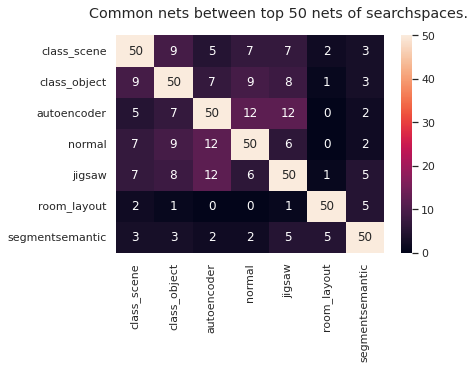

In [78]:
n_largest = 50
inds, common_nets = common_n_largest(dfs, n_largest=n_largest)

plot_common_networks(common_nets, inds, n_largest=n_largest)
plt.show()

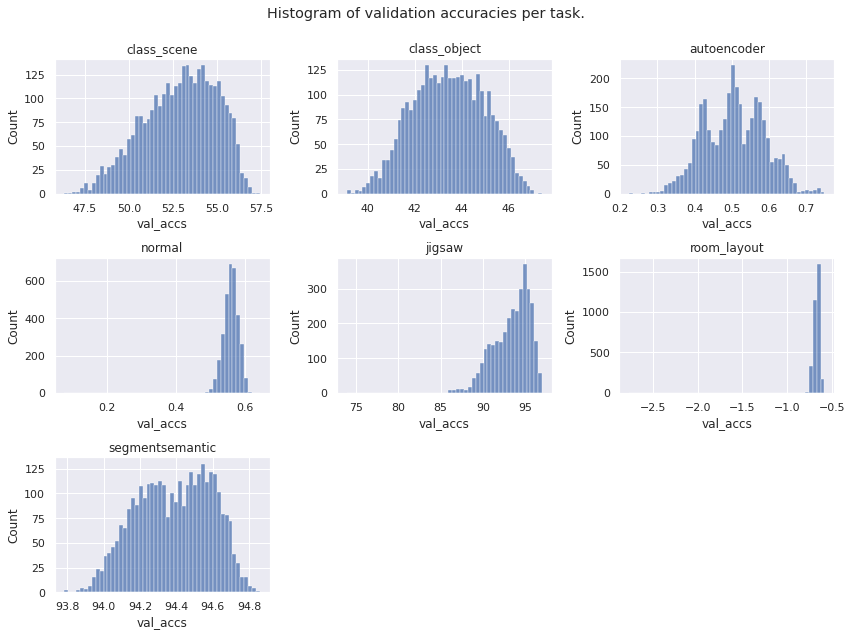

In [79]:
plot_accuracy_histogram(dfs)
plt.show()

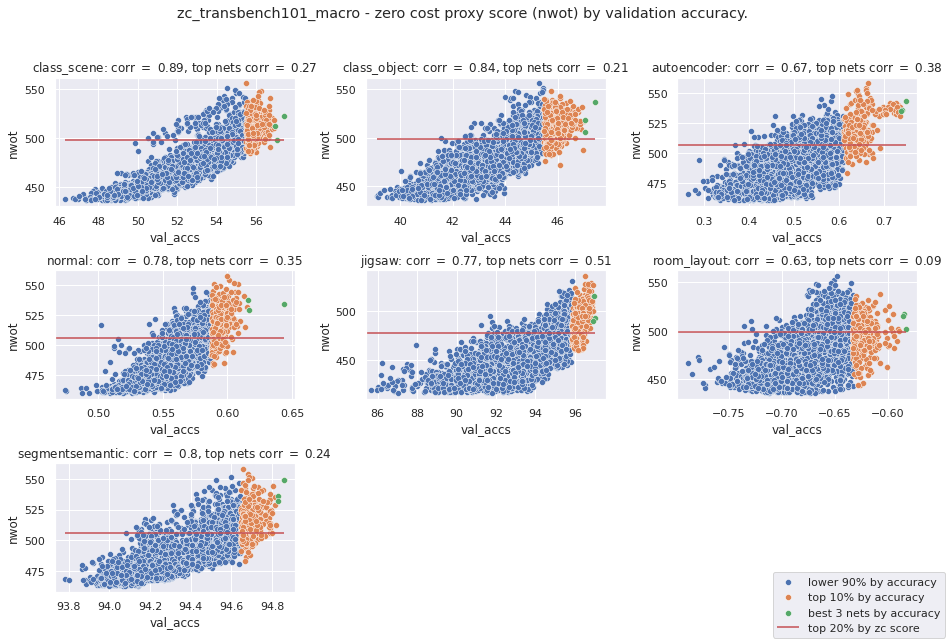

In [13]:
zc = 'nwot'

top_k = 3
acc_quantile = 0.9
zc_quantile = 0.8
dfs_stats = eval_zc(dfs, zc, top_k=top_k, acc_quantile=acc_quantile)

q = int(100 - acc_quantile * 100)
low_q = int(acc_quantile * 100)
zc_q = int(100 - zc_quantile * 100)

title = f"{what} - zero cost proxy score ({zc}) by validation accuracy."
legend = [f'lower {low_q}% by accuracy', f'top {q}% by accuracy', f'best {top_k} nets by accuracy', f'top {zc_q}% by zc score']
plot_networks_zc(dfs_stats, zc, title, top_line=True, subplots_adjust=0.87, legend=legend, legend_loc='lower right', zc_quantile=zc_quantile, key='corr',
                 figsize=(13, 9))
plt.show()

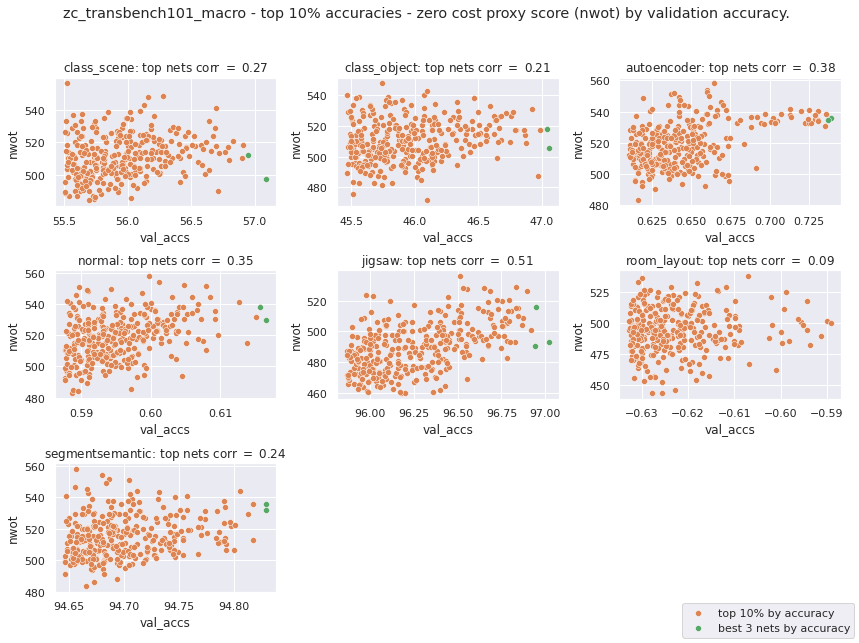

In [14]:
title = f"{what} - top {q}% accuracies - zero cost proxy score ({zc}) by validation accuracy."
legend = [f'top {q}% by accuracy', f'best {top_k} nets by accuracy']
plot_top_quantile_zc(dfs_stats, zc, title, subplots_adjust=0.87, legend=legend, legend_loc='lower right', zc_quantile=zc_quantile, key='corr')
plt.show()

# Combine two proxies

In [10]:
#TODO 90 %
def plot_filtered(dfs, filter_zc, rank_zc, key='tau', **kwargs):
  dfs_filter = filter_by_zc_task(dfs, filter_zc, **kwargs)
  dfs_filtered = eval_zc(dfs, rank_zc, filter_index=dfs_filter)

  title = f"Nets over 90% quantile in {filter_zc}, {rank_zc} by validation accuracy."
  legend = [f'lower 90% nets by accuracy', f'top 10% nets by accuracy', 'best 3 networks']
  plot_networks_zc(dfs_filtered, rank_zc, title, subplots_adjust=0.9, legend=legend, legend_loc='lower right', key=key)
  plt.show()

## Combine fisher and nwot

- fisher does not rank well top 10 % networks

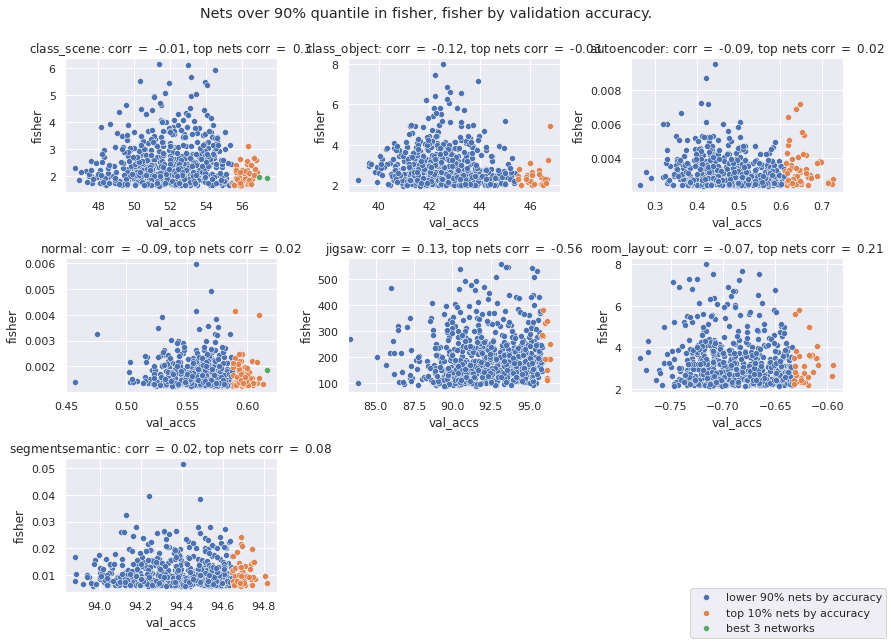

In [11]:
plot_filtered(dfs, 'fisher', 'fisher', quantile=0.8, key='corr')

- nwot is slightly better

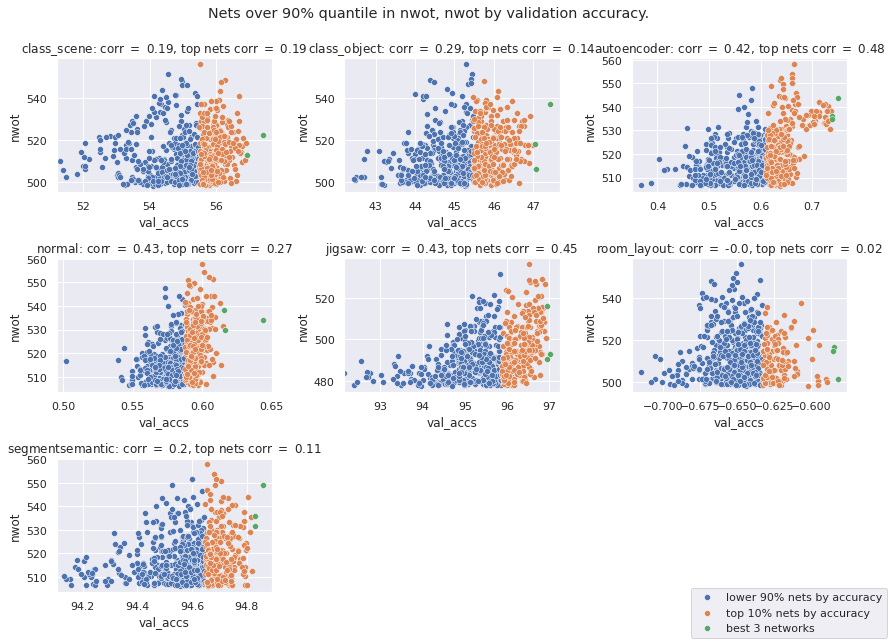

In [12]:
plot_filtered(dfs, 'nwot', 'nwot', quantile=0.8, key='corr')

- select top 10 % networks using fisher
- rank them using nwot
- performance is much better
   - compare with the fisher-fisher case above

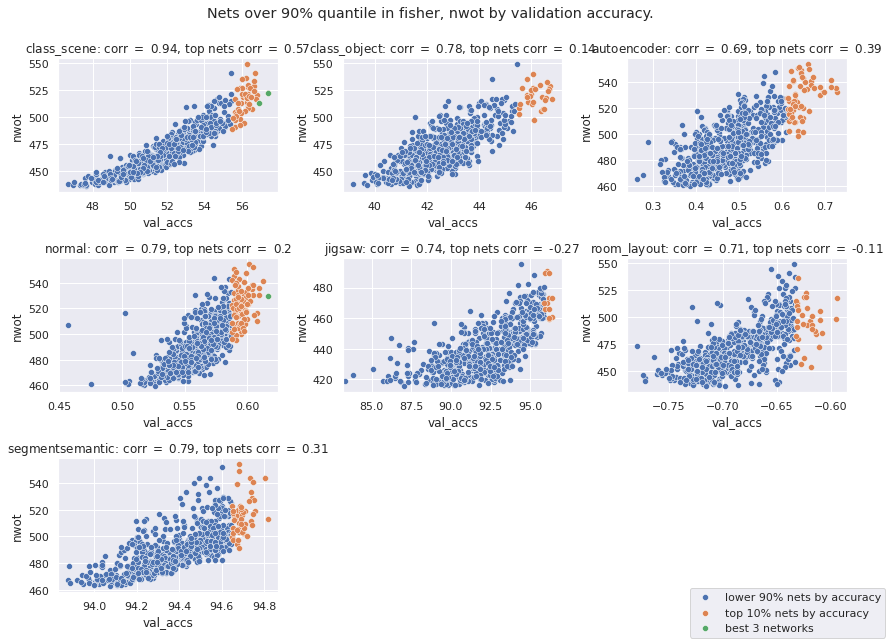

In [15]:
plot_filtered(dfs, 'fisher', 'nwot', quantile=0.8, key='corr')

- reversing the proxies leads to worse results

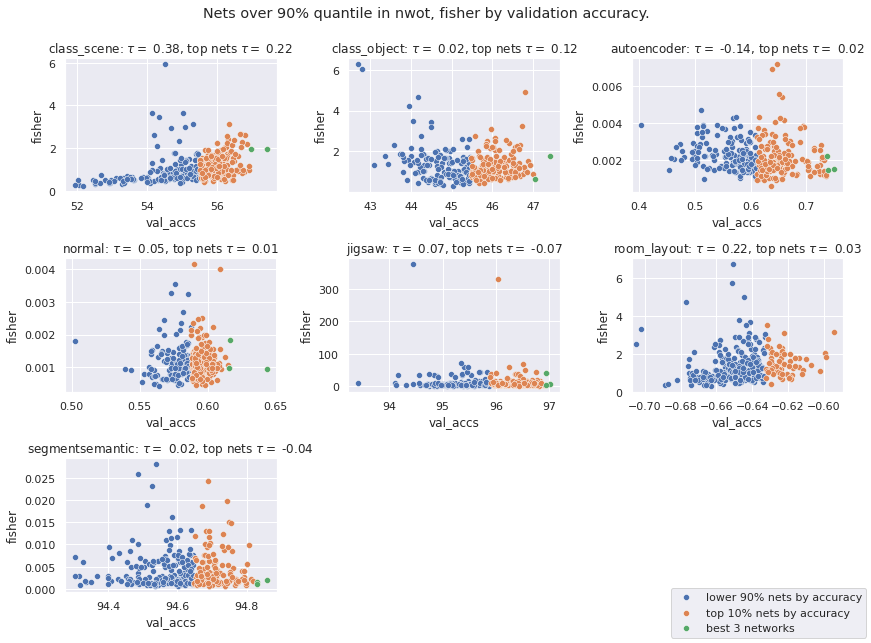

In [86]:
plot_filtered(dfs, 'nwot', 'fisher', quantile=0.9)

## Filter using multiple proxies

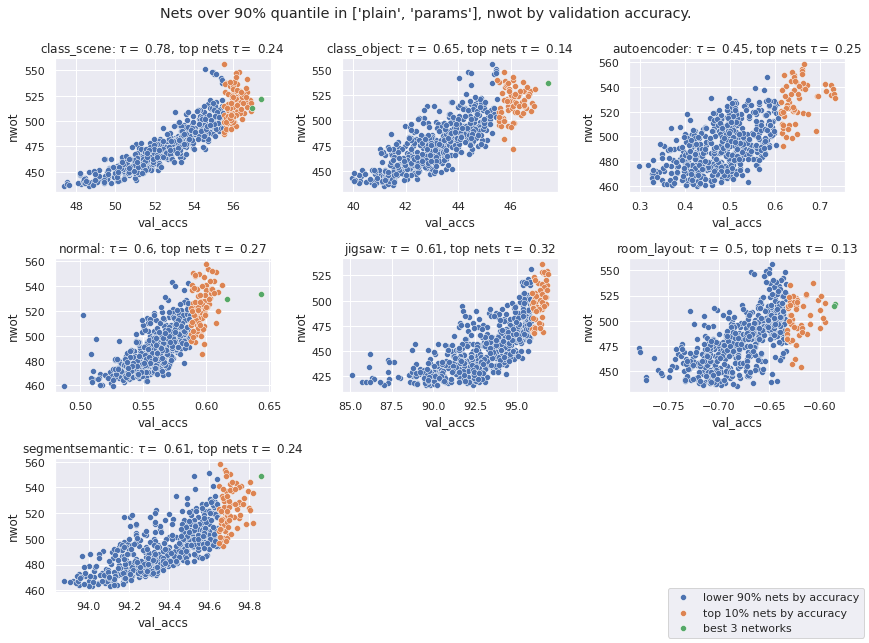

In [87]:
plot_filtered(dfs, ['plain', 'params'], 'nwot', mode='u')

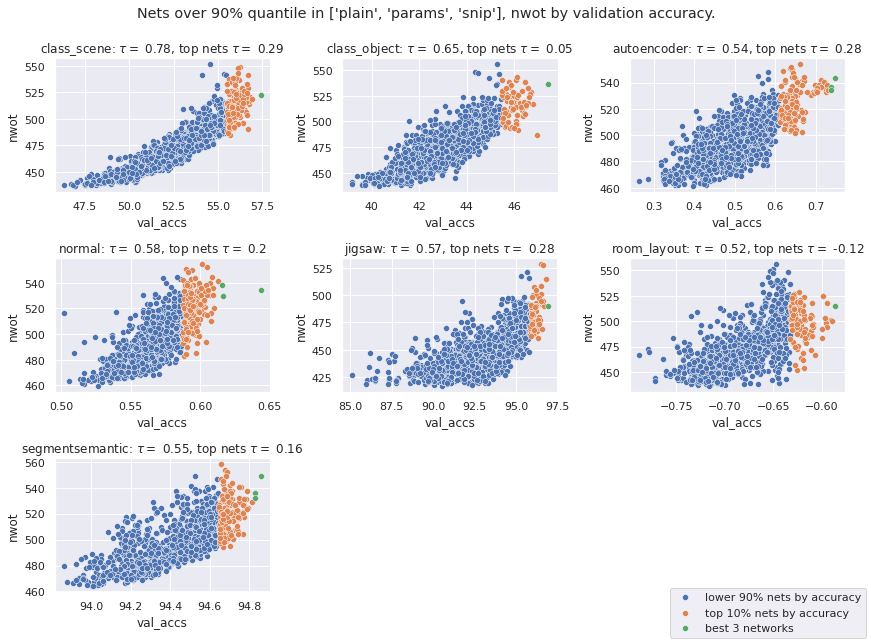

In [88]:
plot_filtered(dfs, ['plain', 'params', 'snip'], 'nwot', mode='s', quantile=[0.3, 0.3, 0.3])

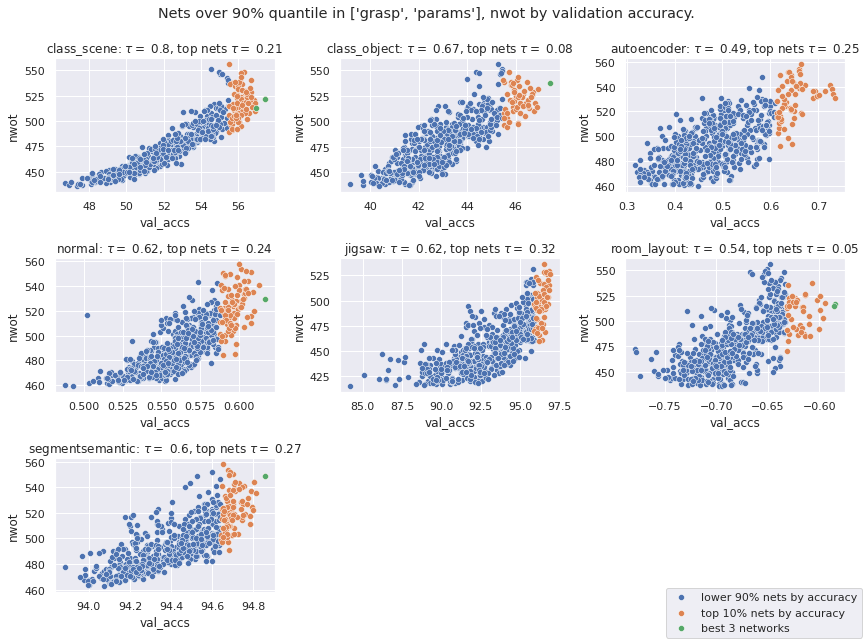

In [89]:
plot_filtered(dfs, ['grasp', 'params'], 'nwot', mode='u')

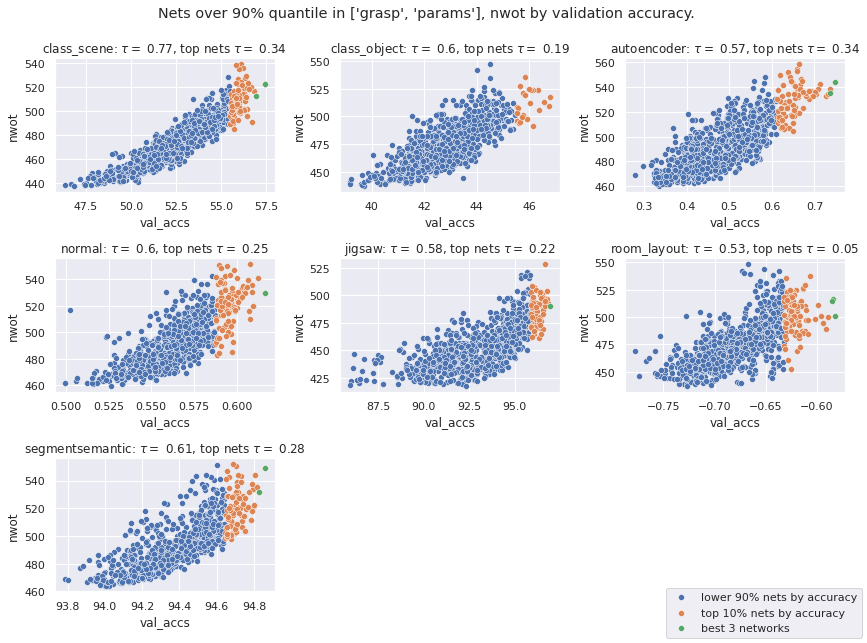

In [90]:
plot_filtered(dfs, ['grasp', 'params'], 'nwot', mode='i', quantile=0.5)

In [24]:
from zc_combine.ensemble.eval import eval_combined_proxies

proxies = [c for c in dfs['cifar10'].columns if c not in ['net', 'val_accs']]
inds, tau_scores = eval_combined_proxies(dfs, proxies, key='corr', zc_quantile=0.8)

/home/gabi/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [25]:
tau_scores.keys()

dict_keys(['cifar10', 'cifar100', 'ImageNet16-120', 'ninapro', 'svhn', 'scifar100'])

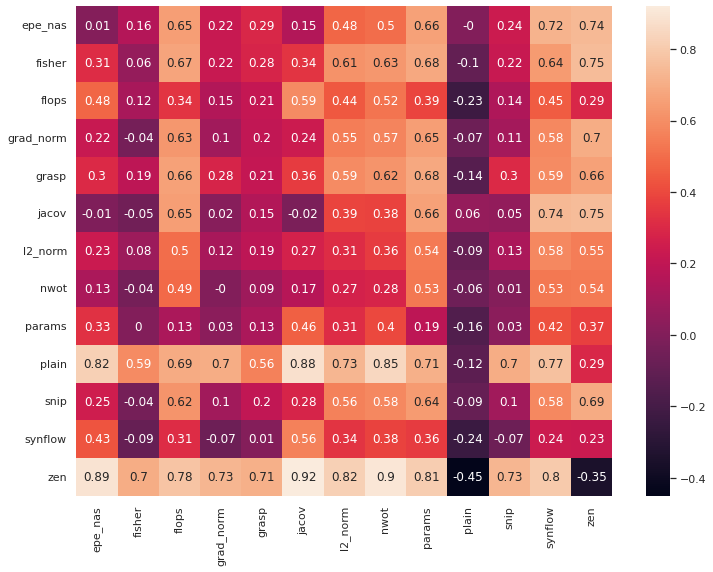

In [26]:
plt.figure(figsize=(12,9))
names = [inds[i] for i in range(len(inds))]
sns.heatmap(tau_scores['cifar10'], annot=True, xticklabels=names, yticklabels=names)
plt.show()

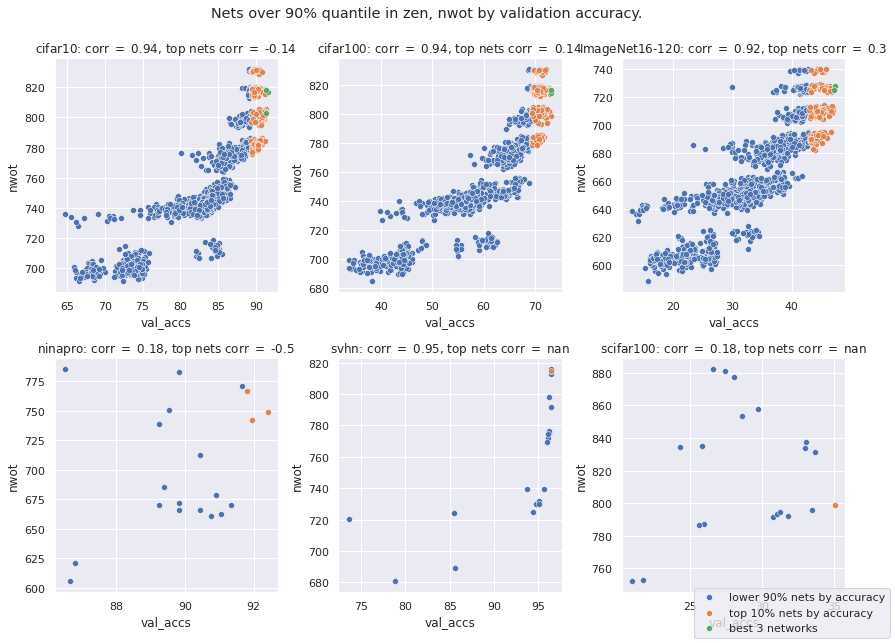

In [27]:
plot_filtered(dfs, 'zen', 'nwot', quantile=0.9, key='corr')  # TODO do correlation instead of tau

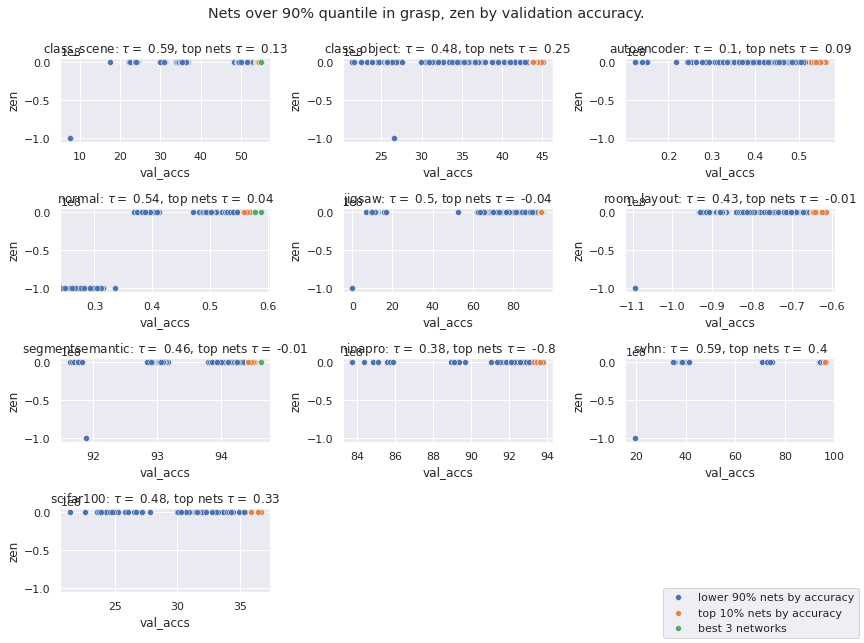

In [30]:
plot_filtered(dfs, 'grasp', 'zen', quantile=0.7)  # TODO do correlation instead of tau